In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
pip install nltk

In [8]:
import re
import nltk
import gensim
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from sklearn.metrics import ConfusionMatrixDisplay,PrecisionRecallDisplay,accuracy_score,confusion_matrix
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Functions

In [9]:
# Functions
 #Preprocess the dataset
def preprocess_text(text):

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert to lowercase
    text = text.lower()
#     stop_words = set(stopwords.words('english'))
#     text = text.split()
#     text = [word for word in text if word not in stop_words]
    return text

# Tokenize the text
def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    return tokens

# Train the Word2Vec model
def train_word2vec_model(tokenized_text):
    model = gensim.models.Word2Vec(
        tokenized_text,
        vector_size=300,  # Size of the word vectors
        window=5,          # Maximum distance between the current and predicted word within a sentence
        min_count=5,      # Ignore words with a frequency lower than this
        negative=20,
        workers=3,
        epochs=20,
        sg=1, # 1 for skip-gram, 0 for CBOW
        hs=1, # 0 for negative sampling, 1 for hierarchical softmax
        sample=0.001,
        alpha=0.025,
        min_alpha=0.0001,
        seed=14,

    )
    return model


#         return np.mean(vectors, axis=0)
def convert_text_to_vectors(tokenized_text, word2vec_model):
    vectors = []
    for token in tokenized_text:
        if token in word2vec_model.wv.key_to_index:
            vectors.append(word2vec_model.wv.get_vector(token))
    if len(vectors) == 0:
        return np.zeros(word2vec_model.vector_size)
    else:
        return np.mean(vectors, axis=0)

In [10]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/subreddits(3).csv')

data['Text'] = data['Text'].apply(preprocess_text)

# Tokenize the text
data['tokens'] = data['Text'].apply(tokenize_text)


In [11]:
data.head()

,Title,Text,Subreddit,tokens
0,"Does it feel like your brain ""short circuits""?",this has happened once before only during a pa...,Anxiety,"[this, has, happened, once, before, only, duri..."
1,Does anyone else feel comforted by lying on th...,when im really anxious a lot of times my insti...,Anxiety,"[when, im, really, anxious, a, lot, of, times,..."
2,Anxiety about Hentai,hey\n\ni know this may seem completely odd for...,Anxiety,"[hey, i, know, this, may, seem, completely, od..."
3,Trying to do my best - unsure if an obsession,ive been diagnosed with gad for quite sometime...,Anxiety,"[ive, been, diagnosed, with, gad, for, quite, ..."
4,How do I get over my fear of driving/ getting ...,i live in ohio and i would like to learn how t...,Anxiety,"[i, live, in, ohio, and, i, would, like, to, l..."


In [12]:
# Train the Word2Vec model
word2vec_model = train_word2vec_model(data['tokens'])

# Convert text to word vectors
data['vectors'] = data['tokens'].apply(lambda x: convert_text_to_vectors(x, word2vec_model))


In [13]:
similar_words = word2vec_model.wv.most_similar("depression", topn=6)
print("similar to 'depression':", similar_words)

similar to 'depression': [('anxiety', 0.5578041076660156), ('disorder', 0.496341347694397), ('gad', 0.48071008920669556), ('adhd', 0.45487821102142334), ('severe', 0.45462897419929504), ('depressionanxiety', 0.452343612909317)]


In [14]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['vectors'], data['Subreddit'], test_size=0.2, random_state=42)

# Train the SVM classifier
svm = SVC(kernel='linear',C=1.0)
svm.fit(list(X_train), y_train)

# Evaluate the classifier
y_pred = svm.predict(list(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Anxiety       0.84      0.79      0.82      2019
  depression       0.80      0.84      0.82      1981

    accuracy                           0.82      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.82      0.82      0.82      4000



0.8185


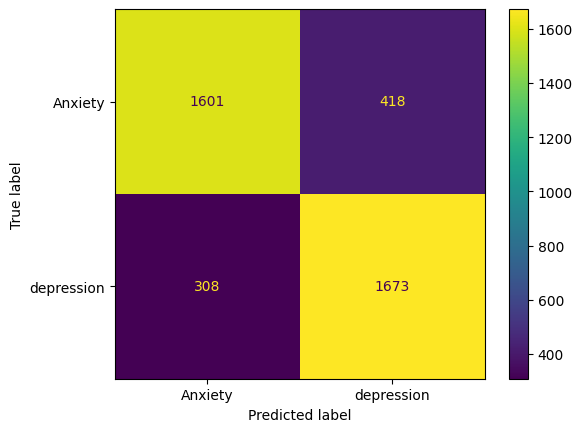

In [15]:
# evalution
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=svm.classes_).plot()
accuracy_sc=accuracy_score(y_test, y_pred)
print(accuracy_sc)

In [16]:
# Train the Logistic Regression classifier
lr = LogisticRegression(max_iter=1000, C=1.0, solver='liblinear')
lr.fit(list(X_train), y_train)

# Evaluate the classifier
y_pred2 = lr.predict(list(X_test))
print(classification_report(y_test, y_pred2))
accuracy_sc2=accuracy_score(y_test, y_pred2)
print(accuracy_sc2)

              precision    recall  f1-score   support

     Anxiety       0.83      0.79      0.81      2019
  depression       0.80      0.83      0.81      1981

    accuracy                           0.81      4000
   macro avg       0.81      0.81      0.81      4000
weighted avg       0.81      0.81      0.81      4000

0.81225


In [26]:
# Train the Naive Bayes classifier
nb = MultinomialNB()
nb.fit(np.abs(list(X_train)), y_train)

# Evaluate the classifier
y_pred3 = lr.predict(list(X_test))
print(classification_report(y_test, y_pred3))
accuracy_sc2=accuracy_score(y_test, y_pred3)
print(accuracy_sc2)

              precision    recall  f1-score   support

     Anxiety       0.83      0.79      0.81      2019
  depression       0.80      0.83      0.81      1981

    accuracy                           0.81      4000
   macro avg       0.81      0.81      0.81      4000
weighted avg       0.81      0.81      0.81      4000

0.81225
